In [1]:
# %pip install -U pretty_midi
# %pip install matplotlib
# %pip install seaborn
import pretty_midi
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-08-06 19:38:00.805263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lisanvo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_dir = "Four_composers"
class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [3]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None, None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None, None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    # Get piano roll
    piano_roll = midi_data.get_piano_roll()
    
    # Note density
    note_density = np.mean(np.sum(piano_roll > 0, axis=0))
    
    # Pitch variance
    active_pitches = np.where(piano_roll > 0)[0]
    pitch_variance = np.var(active_pitches) if len(active_pitches) > 0 else 0
    
    # Velocity statistics
    velocities = [note.velocity for instrument in midi_data.instruments for note in instrument.notes]
    avg_velocity = np.mean(velocities) if velocities else 0
    max_velocity = np.max(velocities) if velocities else 0
    velocity_variance = np.var(velocities) if velocities else 0
    
    # Polyphony
    polyphony = np.max(np.sum(piano_roll > 0, axis=0))
    
    # Rhythmic density
    rhythmic_density = np.sum(np.sum(piano_roll > 0, axis=0) > 0) / piano_roll.shape[1]
    
    # Pitch intervals
    all_notes = sorted([(note.start, note.pitch) for instrument in midi_data.instruments for note in instrument.notes])
    intervals = [abs(all_notes[i+1][1] - all_notes[i][1]) for i in range(len(all_notes)-1)]
    avg_interval = np.mean(intervals) if intervals else 0
    
    # Chord density
    chord_density = np.mean(np.sum(piano_roll > 0, axis=0) >= 3)
    
    # Pitch transitions
    pitch_transitions = np.sum(np.diff(piano_roll > 0, axis=1) > 0) / (piano_roll.shape[1] - 1)
    
    # Sustained notes
    note_durations = [note.end - note.start for instrument in midi_data.instruments for note in instrument.notes]
    avg_note_duration = np.mean(note_durations) if note_durations else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    features = [
        tempo, num_instruments, note_density, pitch_variance, 
        avg_velocity, max_velocity, velocity_variance,
        polyphony, rhythmic_density, avg_interval, 
        chord_density, pitch_transitions, avg_note_duration, 
        key
    ] + pitch_classes

    feature_names = [
        'tempo', 'num_instruments', 'note_density', 'pitch_variance',
        'avg_velocity', 'max_velocity', 'velocity_variance',
        'polyphony', 'rhythmic_density', 'avg_interval',
        'chord_density', 'pitch_transitions', 'avg_note_duration',
        'key'
    ] + [f'pitch_class_{i}' for i in range(12)]

    return features, feature_names

X = []
y = []
error_count = 0
all_feature_names = None

for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features, feature_names = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                        if all_feature_names is None:
                            all_feature_names = feature_names
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")
else:
    print(f"Total errors encountered: {error_count}")

Error parsing MIDI file Four_composers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipping file Four_composers/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid due to errors
Error parsing MIDI file Four_composers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Skipping file Four_composers/Beethoven/Anhang 14-3.mid due to errors
Total errors encountered: 2


### Convert X and y to a Pandas dataframe of selected features

In [4]:
X_np = np.array(X)
y_np = np.array(y)

# Create the DataFrame
df = pd.DataFrame(X_np, columns=all_feature_names)
df['composer'] = y_np

### Visualize tempo distribution of the compositions.

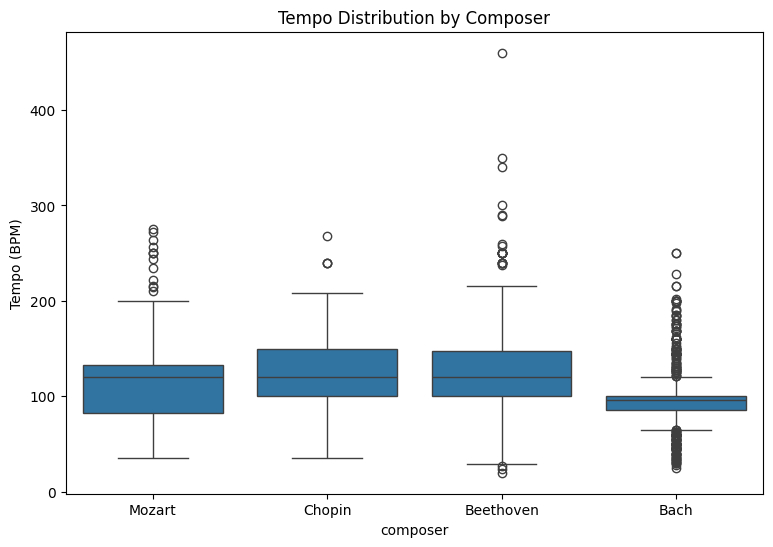

In [5]:
# Create a box plot
plt.figure(figsize=(9, 6))
sns.boxplot(x='composer', y='tempo', data=df)
plt.title('Tempo Distribution by Composer')
plt.ylabel('Tempo (BPM)')
plt.show()

### Visualize the average velocity distribution of the compositions.

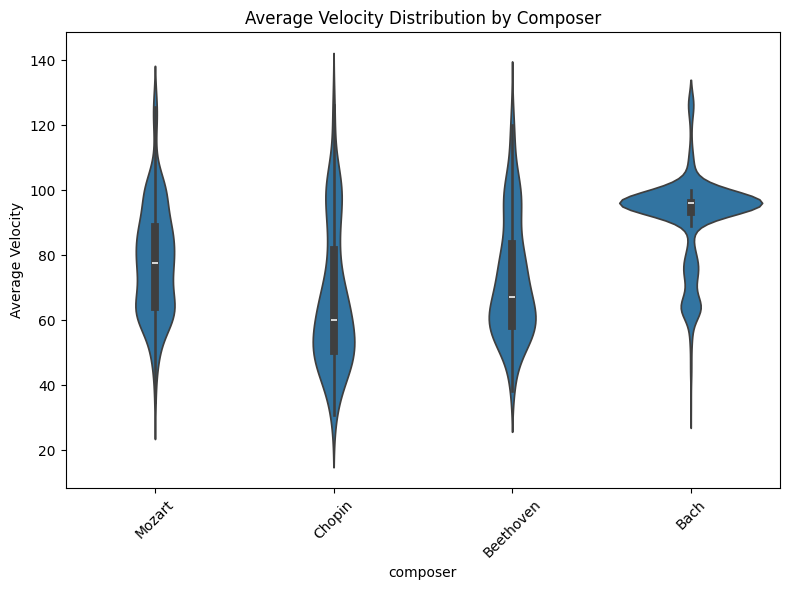

In [6]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='composer', y='avg_velocity', data=df)
plt.title('Average Velocity Distribution by Composer')
plt.ylabel('Average Velocity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize the number of instruments vs average velocity, by composer

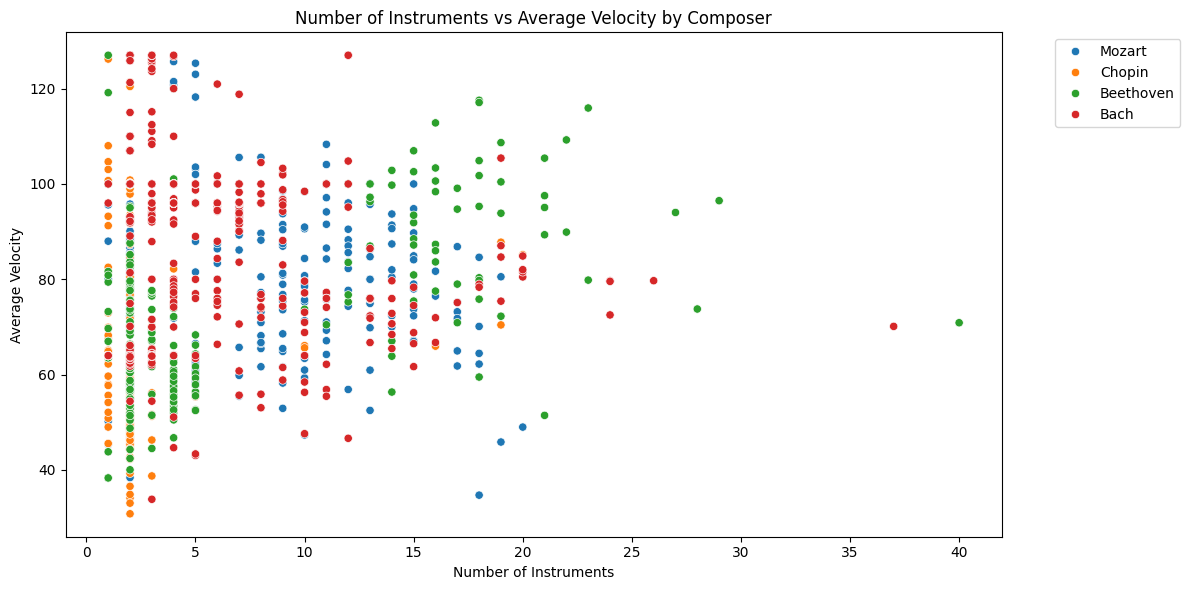

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_instruments', y='avg_velocity', hue='composer', data=df)
plt.title('Number of Instruments vs Average Velocity by Composer')
plt.xlabel('Number of Instruments')
plt.ylabel('Average Velocity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Visualize the normalized pitch class (note) by composer

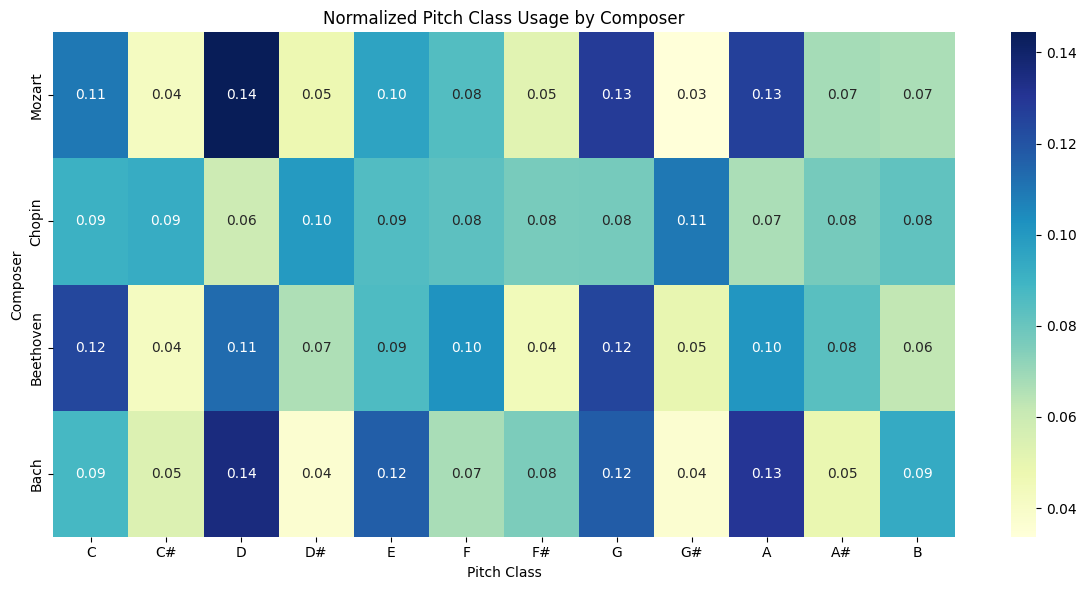

In [8]:
composition_counts = df['composer'].value_counts()   # Count the number of compositions per composer

normalized_df = pd.DataFrame()           # Create a new DataFrame for normalized pitch class usage

# Iterate through each composer
for composer in df['composer'].unique():
    composer_data = df[df['composer'] == composer]   # Let composer_data be data for the current composer
    pitch_class_sums = composer_data[[f'pitch_class_{i}' for i in range(12)]].sum()      # Sum the pitch class values for this composer
    total_sum = pitch_class_sums.sum()                          # Sum the pitch classes
    normalized_pitch_classes = pitch_class_sums / total_sum     # Normalize by dividing by the total sum of all pitch classes
    normalized_df[composer] = normalized_pitch_classes

normalized_df = normalized_df.T                      # Transpose the DataFrame so composers are rows and pitch classes are columns

pitch_class_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
normalized_df.columns = pitch_class_names            # Rename columns to pitch class names

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Normalized Pitch Class Usage by Composer')
plt.xlabel('Pitch Class')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

### Pair-plot to visualize the four selected features.

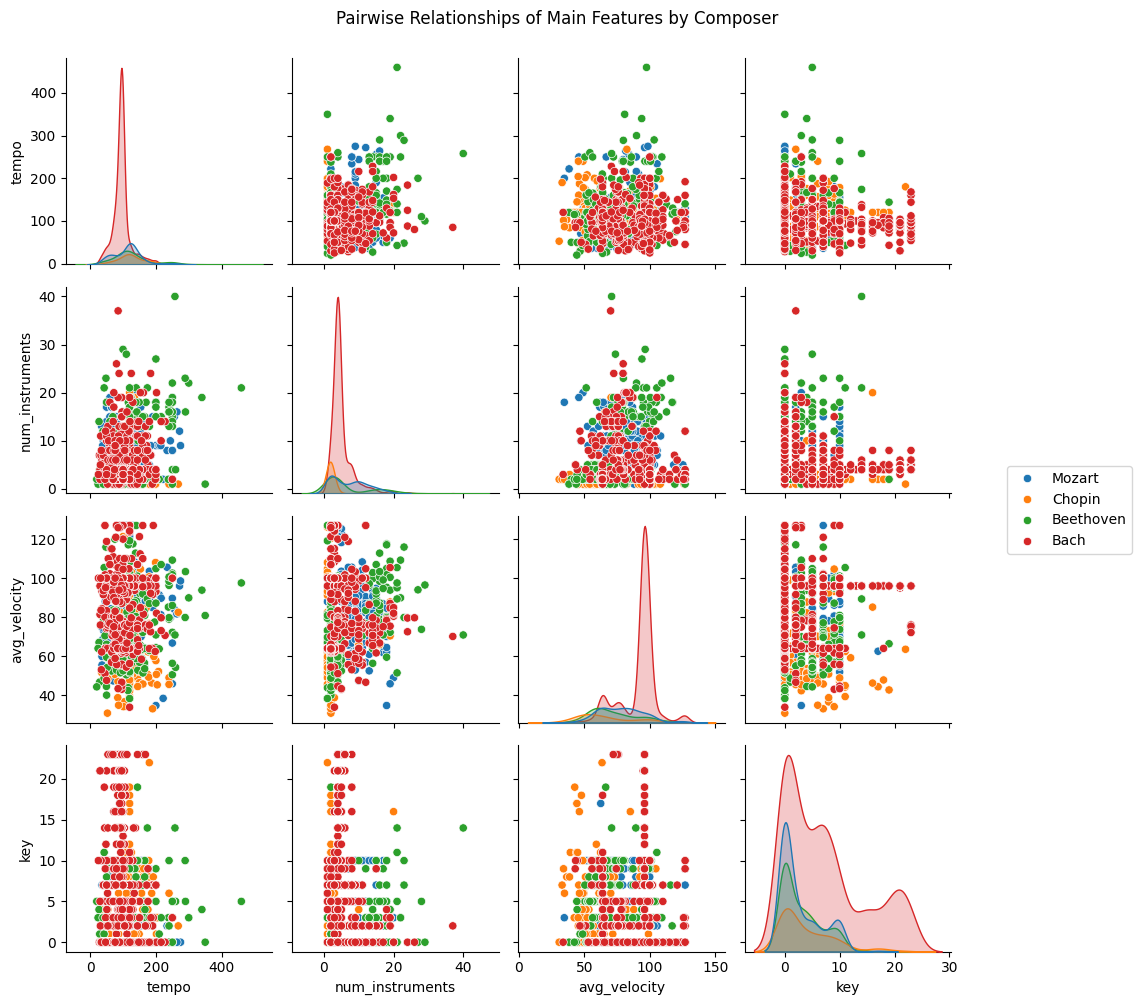

In [9]:
# Pairplot for main features
main_features = ['tempo', 'num_instruments', 'avg_velocity', 'key']
g = sns.pairplot(df[main_features + ['composer']], hue='composer', vars=main_features)
g._legend.remove()     # Remove the original legend

handles = g._legend.legend_handles
labels = g._legend.get_texts()
unique_labels = list(dict.fromkeys([t.get_text() for t in labels]))  # Remove duplicates while preserving order
unique_handles = [handles[next(i for i, t in enumerate(labels) if t.get_text() == label)] for label in unique_labels]

g.fig.legend(unique_handles, unique_labels, bbox_to_anchor=(0.9, 0.5), loc='center left', borderaxespad=0)
plt.suptitle('Pairwise Relationships of Main Features by Composer', y=1)
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the right margin to make room for the legend
plt.show()

### Radar plot of pitch class usage

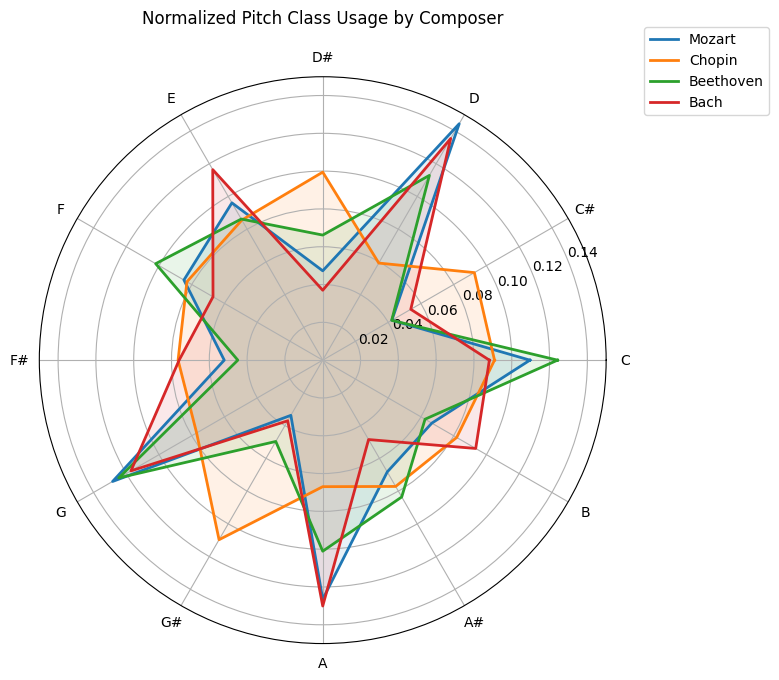

In [10]:
# Set up the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

# Number of variables
num_vars = len(pitch_class_names)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
angles += angles[:1]

# Plot data for each composer
for composer in normalized_df.index:
    values = normalized_df.loc[composer].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=composer)
    ax.fill(angles, values, alpha=0.1)

# Set the labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(pitch_class_names)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('Normalized Pitch Class Usage by Composer', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

### Visualize the degree of musical chromaticism by plotting the proportion of non-diatonic notes used in each key signature.

In [11]:
df['base_key'] = df['key'] % 12
df['mode'] = np.where(df['key'] < 12, 'Major', 'Minor')

# Dictionary that map numbers to key names
key_names = {0: 'C', 1: 'C#/Db', 2: 'D', 3: 'D#/Eb', 4: 'E', 5: 'F', 6: 'F#/Gb', 7: 'G', 8: 'G#/Ab', 9: 'A', 10: 'A#/Bb', 11: 'B'}

# Map the base_key to key names
df['key_name'] = df['base_key'].map(key_names)

# Print number of compositions in each key
print('Number of compositions in each key.')
print(df.groupby(['key_name', 'mode']).size().unstack(fill_value=0))

# Print total counts for each base key
print("\nTotal counts for each key:")
print(df['key_name'].value_counts().sort_index())

# Print total counts for each mode
print("\nTotal counts for each mode:")
print(df['mode'].value_counts())

Number of compositions in each key.
mode      Major  Minor
key_name              
A            72     63
A#/Bb        94      1
B             7     37
C           558      8
C#/Db        15      1
D           122     40
D#/Eb        89      0
E            32     35
F           120      5
F#/Gb        10      8
G           151     38
G#/Ab        22      0

Total counts for each key:
key_name
A        135
A#/Bb     95
B         44
C        566
C#/Db     16
D        162
D#/Eb     89
E         67
F        125
F#/Gb     18
G        189
G#/Ab     22
Name: count, dtype: int64

Total counts for each mode:
mode
Major    1292
Minor     236
Name: count, dtype: int64


Moat compositions in the dataset are in the key of C, then G, then D, then A. Most of the compositions are in the major key.

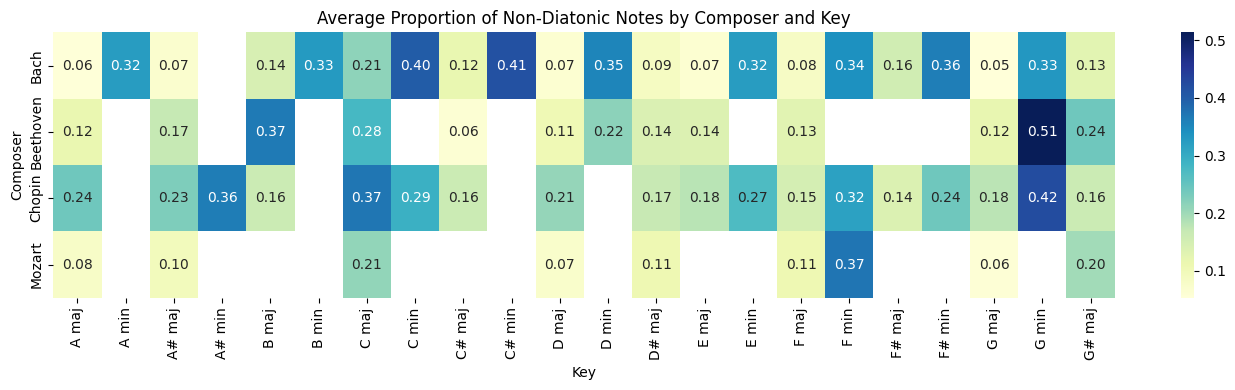

In [12]:
# Convert key numbers to key names

df['key'] = df['key'].astype(int)

def calculate_non_diatonic_proportion(row):
    pitch_classes = [row[f'pitch_class_{i}'] for i in range(12)]
    key = row['key']  # Now this is already an integer
    major_scales = [
        [0, 2, 4, 5, 7, 9, 11],  # C Major
        [1, 3, 5, 6, 8, 10, 0],  # C# Major
        [2, 4, 6, 7, 9, 11, 1],  # D Major
        [3, 5, 7, 8, 10, 0, 2],  # D# Major
        [4, 6, 8, 9, 11, 1, 3],  # E Major
        [5, 7, 9, 10, 0, 2, 4],  # F Major
        [6, 8, 10, 11, 1, 3, 5], # F# Major
        [7, 9, 11, 0, 2, 4, 6],  # G Major
        [8, 10, 0, 1, 3, 5, 7],  # G# Major
        [9, 11, 1, 2, 4, 6, 8],  # A Major
        [10, 0, 2, 3, 5, 7, 9],  # A# Major
        [11, 1, 3, 4, 6, 8, 10]  # B Major
    ]
    diatonic_scale = major_scales[key % 12]
    total_notes = sum(pitch_classes)
    non_diatonic_notes = sum(pitch_classes[i] for i in range(12) if i not in diatonic_scale)   
    return non_diatonic_notes / total_notes if total_notes > 0 else 0

# For each row, what proportion of notes are non-diatonic
df['non_diatonic_prop'] = df.apply(calculate_non_diatonic_proportion, axis=1)

def key_to_name(key):
    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    mode = 'min' if key >= 12 else 'maj'
    return f'{key_names[key % 12]} {mode}'

# Add a new column of df with the key names
df['key_name'] = df['key'].apply(key_to_name)

# Create the pivot table using key names
pivot_df = df.pivot_table(values='non_diatonic_prop', index='composer', columns='key_name', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Proportion of Non-Diatonic Notes by Composer and Key')
plt.xlabel('Key')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

Bach was musically adventurous, and composed in every key. Chopin also was not afraid to use minor key signatures and use non-diatonic notes. Mozart preferred major key signatures and infrequently used non-diatonic notes. Beethoven was somewhere in between, being mostly diatonic, but sometimes very much not so.

### Perform train-test split.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

### Print raw values of X_train and X_test to visualize range

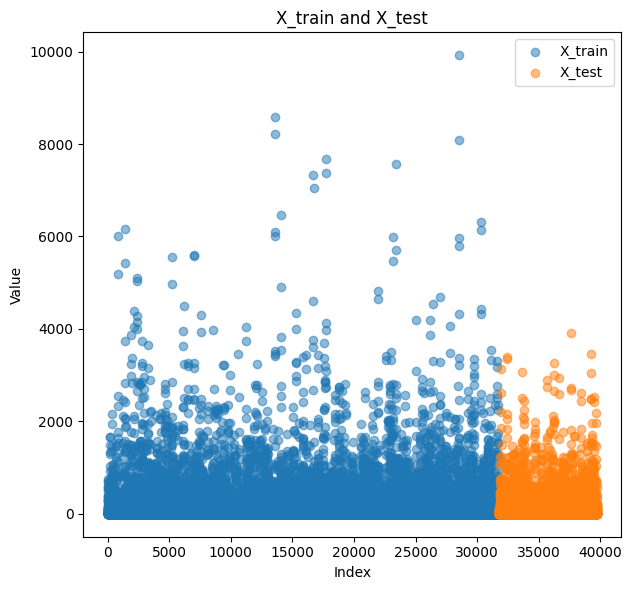

In [14]:
plt.figure(figsize=(12, 6))

def flatten_if_needed(data):
    if len(data.shape) > 1 and data.shape[1] > 1:
        return data.flatten()
    return data

# Plot X_train and X_test
plt.subplot(1, 2, 1)
X_train_flat = flatten_if_needed(X_train)
X_test_flat = flatten_if_needed(X_test)

plt.scatter(range(len(X_train_flat)), X_train_flat, alpha=0.5, label='X_train')
plt.scatter(range(len(X_train_flat), len(X_train_flat) + len(X_test_flat)), X_test_flat, alpha=0.5, label='X_test')
plt.title('X_train and X_test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

Wide range in dataset values suggests the need for normalization of the training and test feature data.

###  Use Standard Scaling on X_train and X_test to normalize the data. 

In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1222, 26)
(306, 26)


### Count the number of MIDI files for each composer in the training set.

In [17]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

Bach         730
Mozart       204
Beethoven    174
Chopin       114
Name: count, dtype: int64

There is a great imbalance in the number of MIDI files available for each composer. Training on such an imbalanced set overfits for the target class with the highest number of datapoints. This should be corrected with SMOTE. 

### SMOTE resampling on the training sets

In [18]:
# %pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Visualize the data imbalance, and correction after SMOTE.

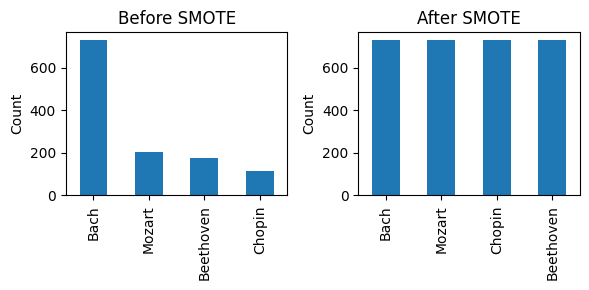

In [19]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

### Use Random Forest classifier to measure relative importance of MIDI features in classification

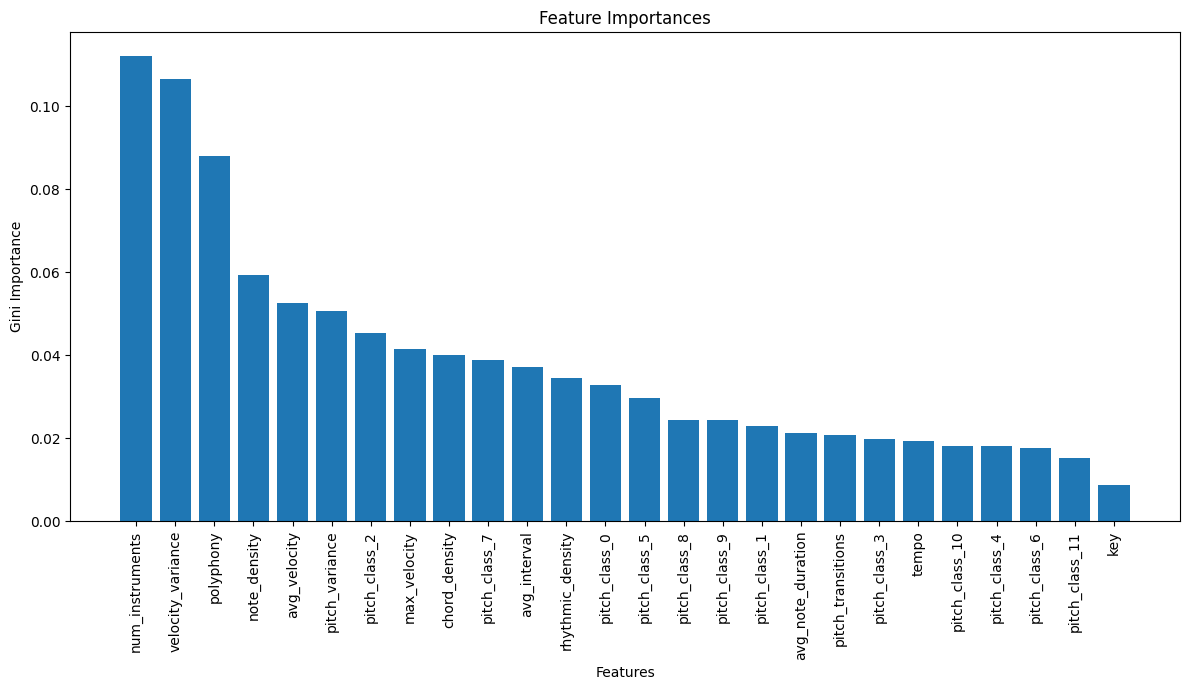

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled_smote, y_train_smote)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 7))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [all_feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

GINI importance measures the decrease in GINI impurity when a feature is used to split the decision tree. A higher Gini importance correlated with greater importance of a feature in making classification predictions. In our feature set, the number of instruments, velocity variance and the use of polyphony were the most important features. 

### Use SHAP to evaluate relative importance of MIDI features
Another way of determining the most important features that predict classification is to use SHAP (Shapley Additive Explanations). 

In [21]:
# %pip install shap
import shap

/Users/lisanvo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Print shapes of our data
print("Shape of X_train_scaled_smote:", X_train_scaled_smote.shape)
print("Number of features in all_feature_names:", len(all_feature_names))

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_scaled_smote)

# Print shape of shap_values
print("Shape of shap_values:", np.array(shap_values).shape)

# Print the number of classes in the target variable (4 composers)
print("Number of unique classes in y_train_smote:", len(np.unique(y_train_smote)))

Shape of X_train_scaled_smote: (2920, 26)
Number of features in all_feature_names: 26
Shape of shap_values: (2920, 26, 4)
Number of unique classes in y_train_smote: 4


Shape of shap_values: (2920, 26, 4)
Shape of X_train_scaled_smote: (2920, 26)
Shape of mean_abs_shap: (26, 4)
Shape of feature_importance: (26, 4)


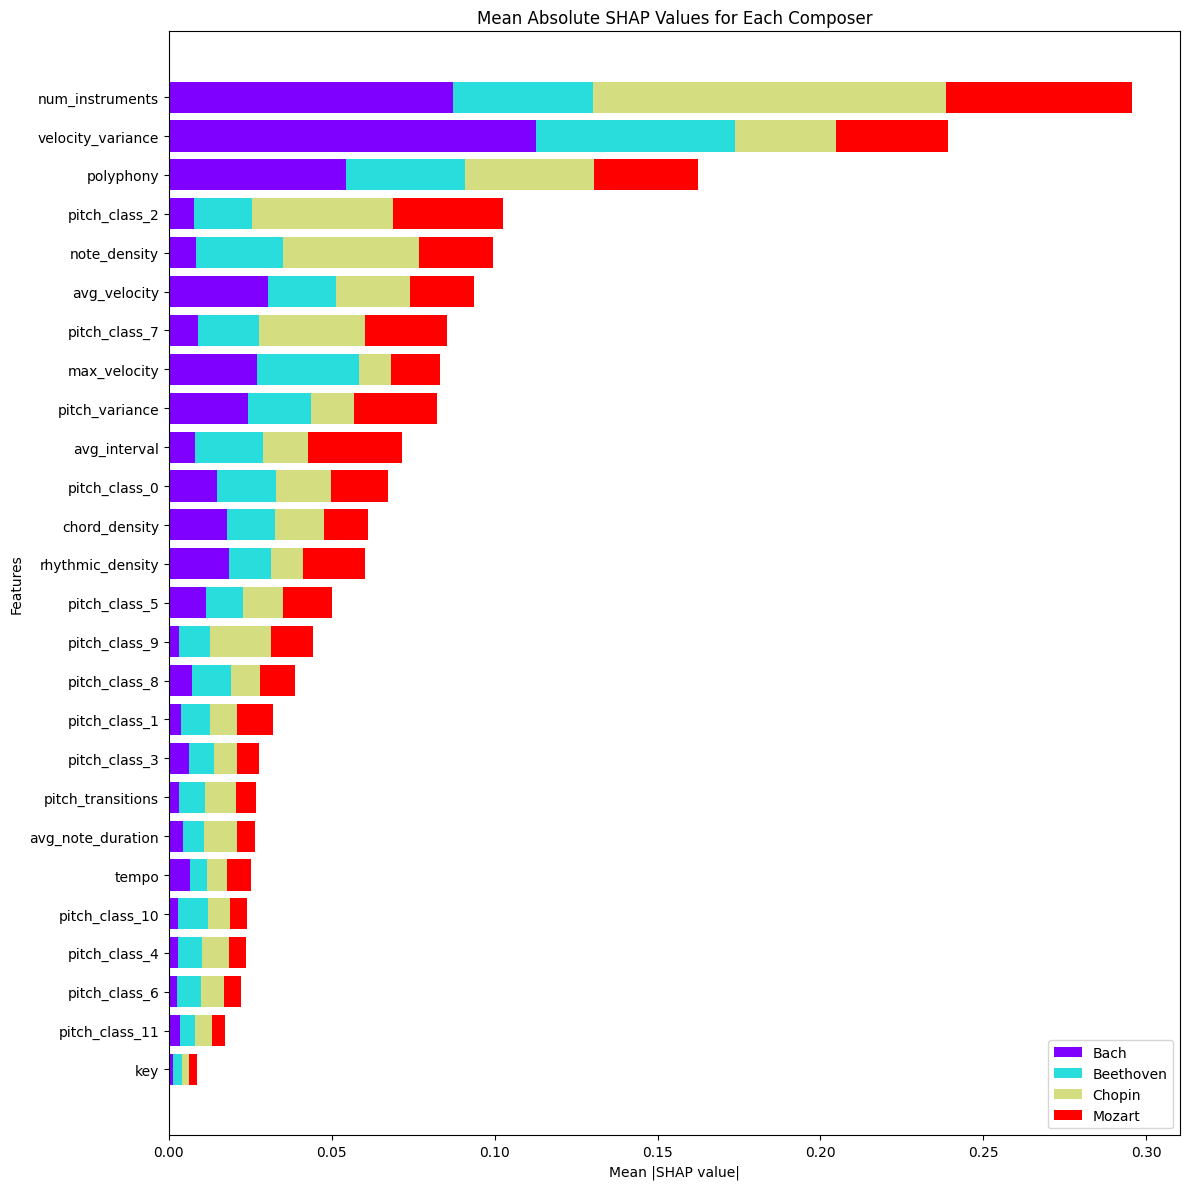

Top 5 Features for Each Composer:

Bach:
velocity_variance: 0.1128
num_instruments: 0.0871
polyphony: 0.0544
avg_velocity: 0.0303
max_velocity: 0.0269

Beethoven:
velocity_variance: 0.0610
num_instruments: 0.0429
polyphony: 0.0365
max_velocity: 0.0313
note_density: 0.0267

Chopin:
num_instruments: 0.1085
pitch_class_2: 0.0433
note_density: 0.0419
polyphony: 0.0394
pitch_class_7: 0.0326

Mozart:
num_instruments: 0.0570
velocity_variance: 0.0343
pitch_class_2: 0.0338
polyphony: 0.0319
avg_interval: 0.0286


In [23]:
# Put X_train_scaled_smote into a DataFrame
df_X_train_scaled_smote = pd.DataFrame(X_train_scaled_smote, columns=all_feature_names)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(df_X_train_scaled_smote)

print("Shape of shap_values:", np.array(shap_values).shape)
print("Shape of X_train_scaled_smote:", df_X_train_scaled_smote.shape)

# Reshape shap_values to match the number of features
reshaped_shap_values = np.array(shap_values).reshape(-1, 26, 4)

# Calculate mean absolute SHAP values for each feature and class
mean_abs_shap = np.mean(np.abs(reshaped_shap_values), axis=0)

print("Shape of mean_abs_shap:", mean_abs_shap.shape)

# Create a color map for composers
#composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']  # Ensure this matches your class order
color_map = plt.colormaps['rainbow'](np.linspace(0, 1, len(class_names)))
composer_colors = dict(zip(class_names, color_map))

# Create DataFrame of feature importances for each composer
feature_importance = pd.DataFrame(mean_abs_shap, columns=class_names, index=df_X_train_scaled_smote.columns)

print("Shape of feature_importance:", feature_importance.shape)

# Sort features by overall importance (descending order)
feature_importance['overall_importance'] = feature_importance[class_names].sum(axis=1)
feature_importance = feature_importance.sort_values('overall_importance', ascending=True)

# Create the stacked bar plot
plt.figure(figsize=(12, 12))

left = np.zeros(len(feature_importance))
for composer in class_names:
    plt.barh(feature_importance.index, feature_importance[composer], left=left, 
             color=composer_colors[composer], label=composer)
    left += feature_importance[composer]

plt.title("Mean Absolute SHAP Values for Each Composer")
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Features")
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

# Print out the top 5 features for each composer
print("Top 5 Features for Each Composer:")
for composer in class_names:
    print(f"\n{composer}:")
    top_features = feature_importance.sort_values(composer, ascending=False)[composer].head(5)
    for feature, value in top_features.items():
        print(f"{feature}: {value:.4f}")

As with the Random Forest Gini importance plot, we see that the most important features were num_instruments, and that it was the most important for classifying Chopin MIDI files, likely due to the preponderance of piano compositions, more so than the other composers. Velocity_variance and polyphony were the next most important features, and they were especially important in classifying the files of Bach. Other features were of more minor importance.

### SHAP analysis by composer

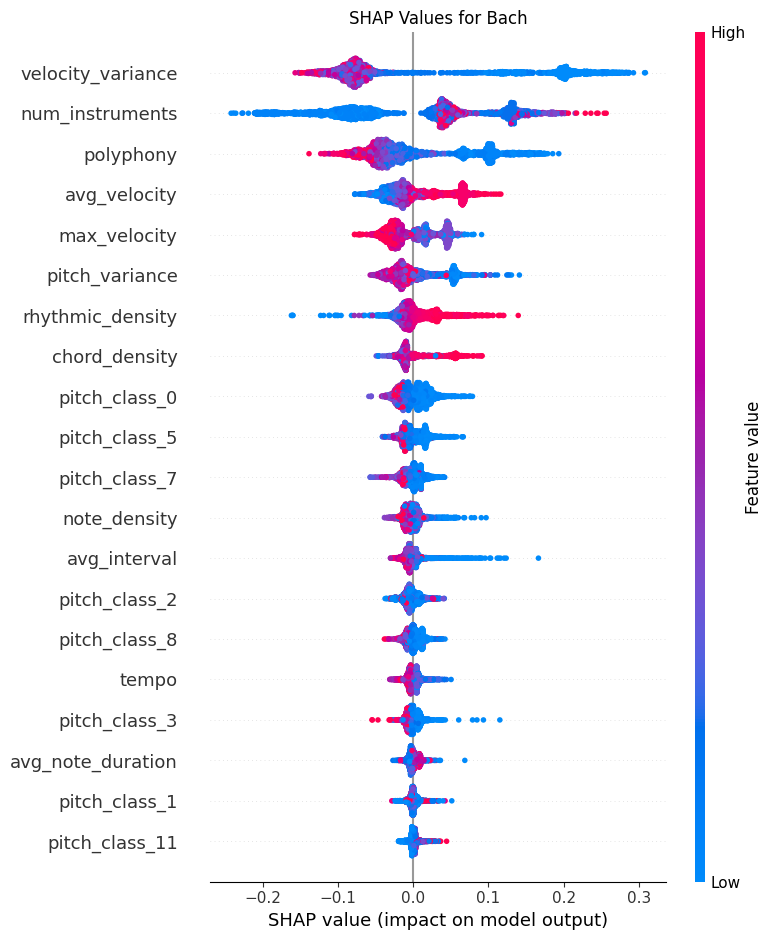

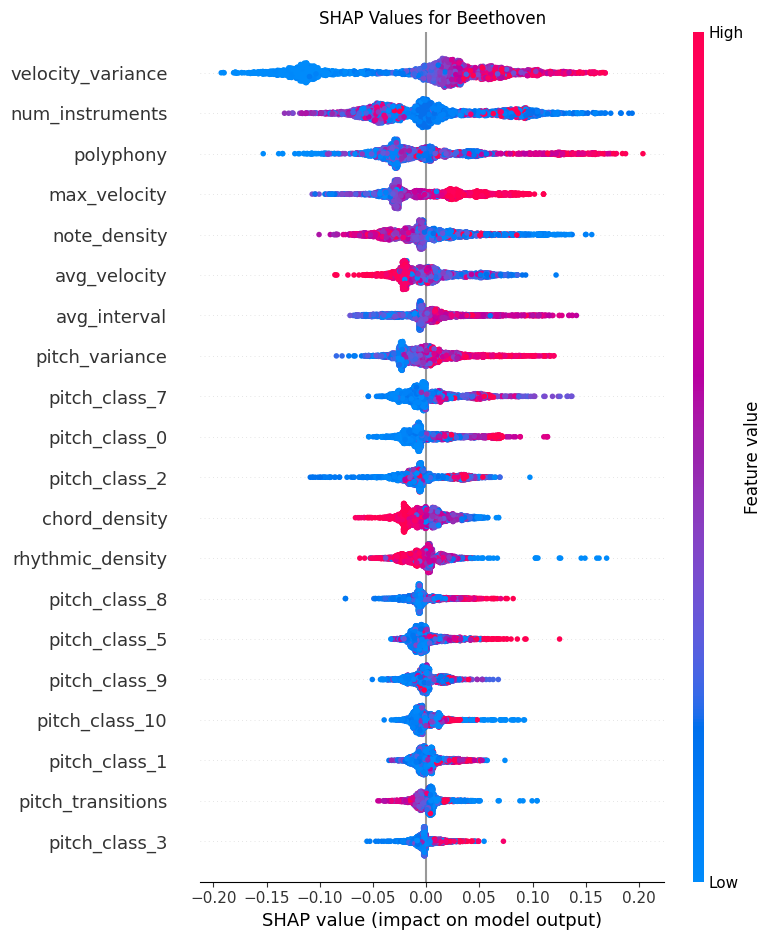

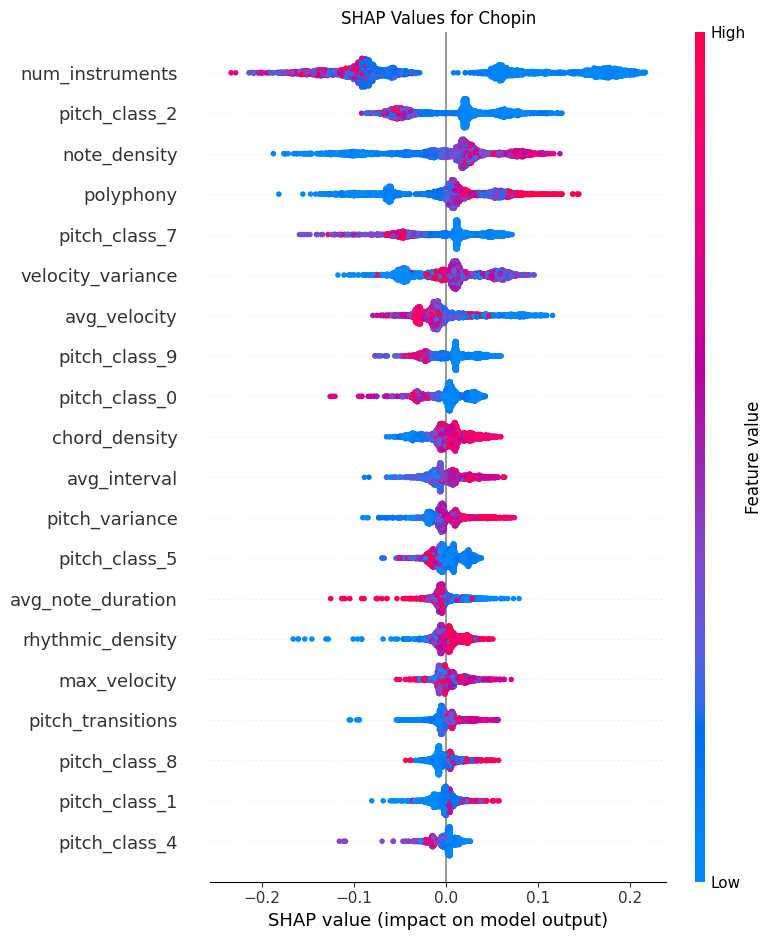

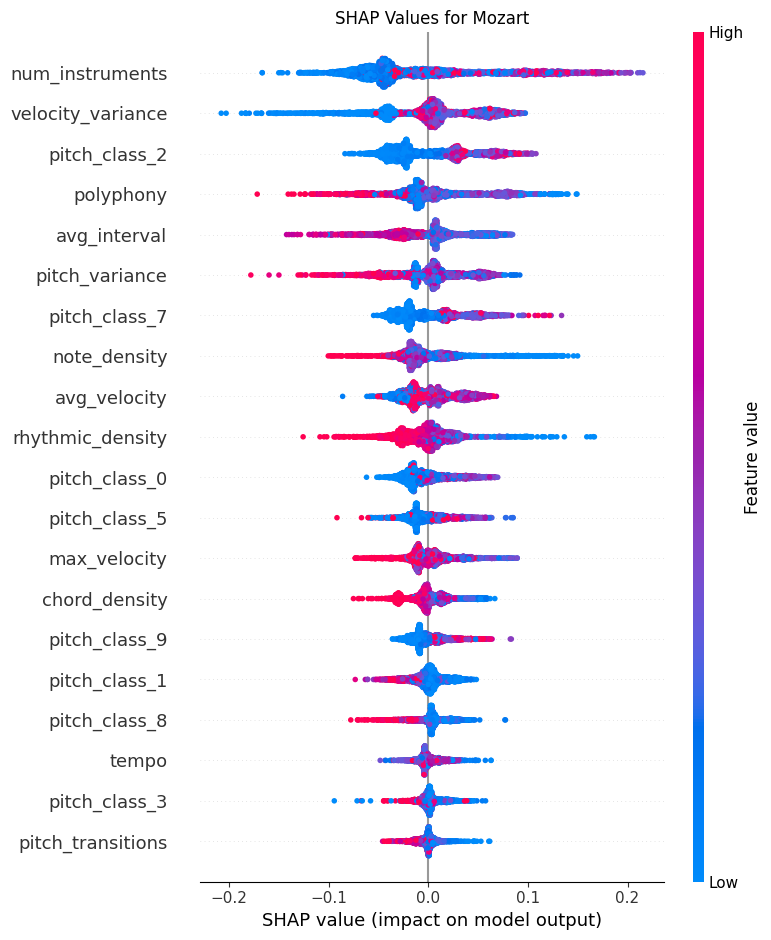

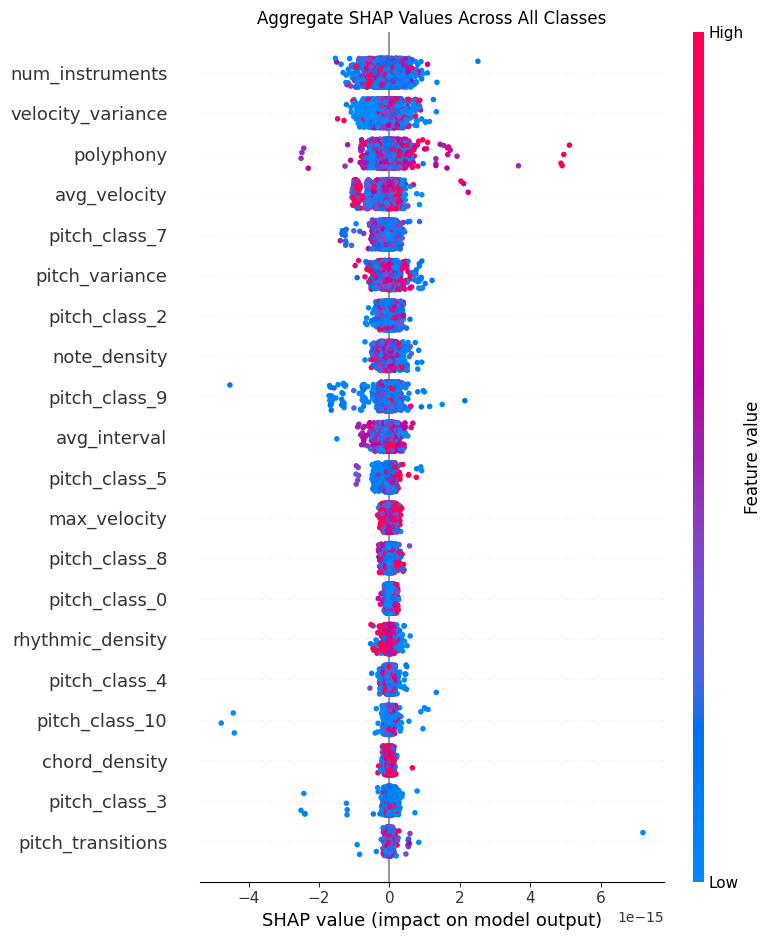

In [24]:
n_classes = shap_values.shape[2]

# Plot detailed SHAP summary for each class
for i in range(n_classes):
    class_shap_values = shap_values[:, :, i]
    shap.summary_plot(class_shap_values, df_X_train_scaled_smote, feature_names=all_feature_names, show=False)
    plt.title(f"SHAP Values for {class_names[i]}")

    plt.tight_layout()
    plt.show()

# Plot aggregate SHAP values
aggregate_shap_values = shap_values.sum(axis=2)
shap.summary_plot(aggregate_shap_values, df_X_train_scaled_smote, feature_names=all_feature_names, show=False)
plt.title("Aggregate SHAP Values Across All Classes")
plt.tight_layout()
plt.show()

These graphs provide a more detailed look into the relative importance of the top 20 features, and how much they contribute to each classification decision. For each composer, velocity_variance, polyphony and num_instruments were consistently among the top of the feature set in terms of importance. 

### SVM

In [25]:
# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
svm_clf.fit(X_train_scaled_smote, y_train_smote)

SVC(C=18.0, degree=5, gamma=0.4)

### Train model using radial basis vector kernel.

In [26]:
y_pred = svm_clf.predict(X_test_scaled)
rbf_accuracy = accuracy_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  81.37
F1 (RBF Kernel):  81.66


In [27]:
# Generate and print the classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bach       0.95      0.93      0.94       195
   Beethoven       0.44      0.78      0.56        37
      Chopin       1.00      0.36      0.53        22
      Mozart       0.75      0.58      0.65        52

    accuracy                           0.81       306
   macro avg       0.78      0.66      0.67       306
weighted avg       0.86      0.81      0.82       306



### Print confusion matrix.

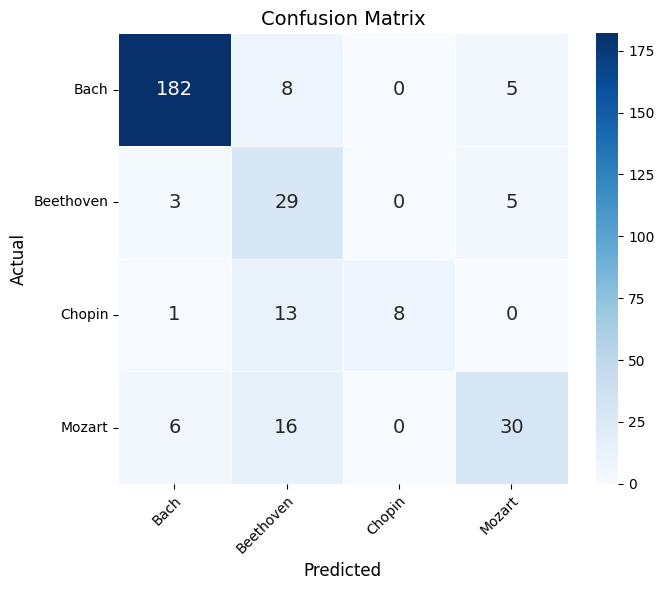

In [28]:
labels = sorted(set(y_test) | set(y_pred))

cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### Print ROC-AUC curves

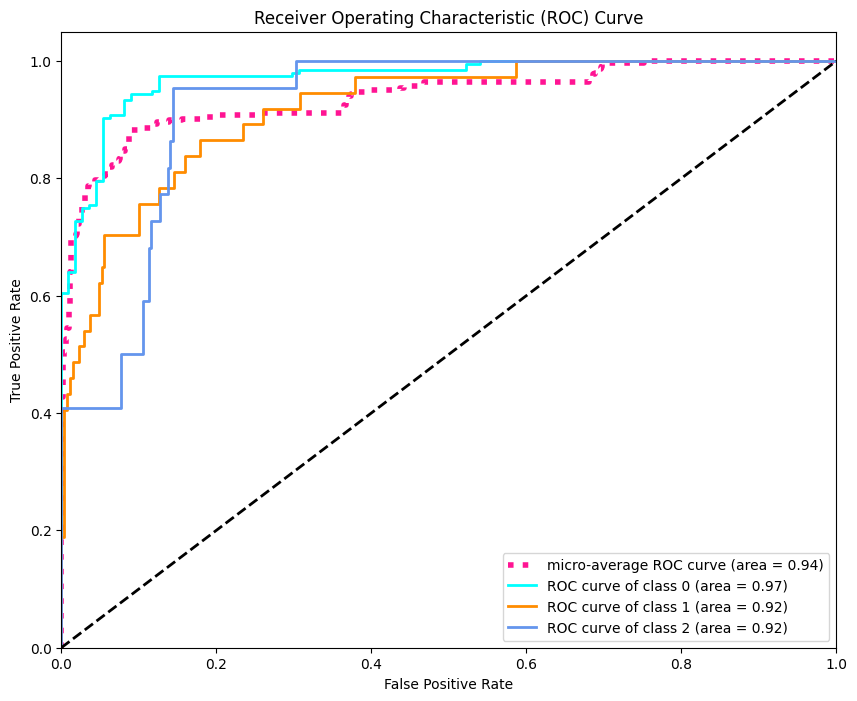

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = svm_clf.decision_function(X_test_scaled)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### LSTM

#### Reshape X train and X test

In [30]:
num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

In [31]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded  = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

In [32]:
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(data.shape[0] - sequence_length + 1):
        seq = data[i:i+sequence_length]
        label = labels[i+sequence_length-1]  # Use the label of the last timestep in the sequence
        sequences.append(seq)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 5  # You can adjust this
X_train_seq, y_train_seq = create_sequences(X_train_reshaped, y_train_categorical, sequence_length)

X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_test_seq, y_test_seq  = create_sequences(X_test_reshaped, y_test_categorical, sequence_length)

#### Build and train model

In [33]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from tensorflow.keras.callbacks import Callback

lstm_model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    BatchNormalization(),
    LSTM(15, return_sequences=True,recurrent_dropout=0.4),
    BatchNormalization(),
    Dropout(0.5),
    
    BatchNormalization(),
    LSTM(5, return_sequences=False,recurrent_dropout=0.4),
    BatchNormalization(),
    Dropout(0.4),

#    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
#    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=30, min_lr=1e-4, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Print statistics every 10 epochs to decrease training clutter
class EpochPrintCallback(Callback):
    def __init__(self, print_every=10):
        super(EpochPrintCallback, self).__init__()
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:
            print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
            print(f"loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
epoch_print = EpochPrintCallback(print_every=10)

# Train the model
result = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=1000,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping, epoch_print], verbose=0)


Epoch 10/1000
loss: 0.4677 - accuracy: 0.8241 - val_loss: 0.4664 - val_accuracy: 0.8311

Epoch 20/1000
loss: 0.4915 - accuracy: 0.8100 - val_loss: 0.4221 - val_accuracy: 0.8311

Epoch 30/1000
loss: 0.4134 - accuracy: 0.8330 - val_loss: 0.4630 - val_accuracy: 0.8113

Epoch 40/1000
loss: 0.4127 - accuracy: 0.8433 - val_loss: 0.4106 - val_accuracy: 0.8311

Epoch 50/1000
loss: 0.4001 - accuracy: 0.8426 - val_loss: 0.5533 - val_accuracy: 0.8046

Epoch 60/1000
loss: 0.4255 - accuracy: 0.8416 - val_loss: 0.4734 - val_accuracy: 0.8311

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.

Epoch 70/1000
loss: 0.3860 - accuracy: 0.8539 - val_loss: 0.4347 - val_accuracy: 0.8344

Epoch 80/1000
loss: 0.3553 - accuracy: 0.8584 - val_loss: 0.4644 - val_accuracy: 0.8377

Epoch 90/1000
loss: 0.3661 - accuracy: 0.8570 - val_loss: 0.4574 - val_accuracy: 0.8344

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.003600000031292438.

Epoch 100/1000
loss: 0.3373 - accuracy: 0.86

#### Evaluate training

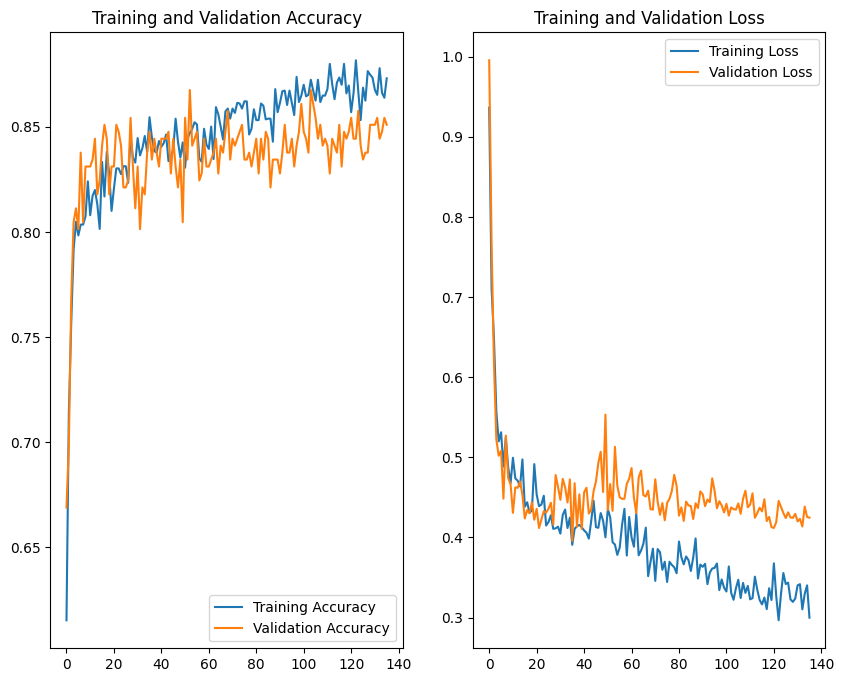

In [34]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make predictions

In [35]:
lstm_model.training=False
y_pred = lstm_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_seq, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [36]:
# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_seq, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       193
           1       0.76      0.53      0.62        36
           2       0.94      0.73      0.82        22
           3       0.60      0.76      0.67        51

    accuracy                           0.85       302
   macro avg       0.81      0.74      0.76       302
weighted avg       0.86      0.85      0.85       302



### Print Confusion matrix

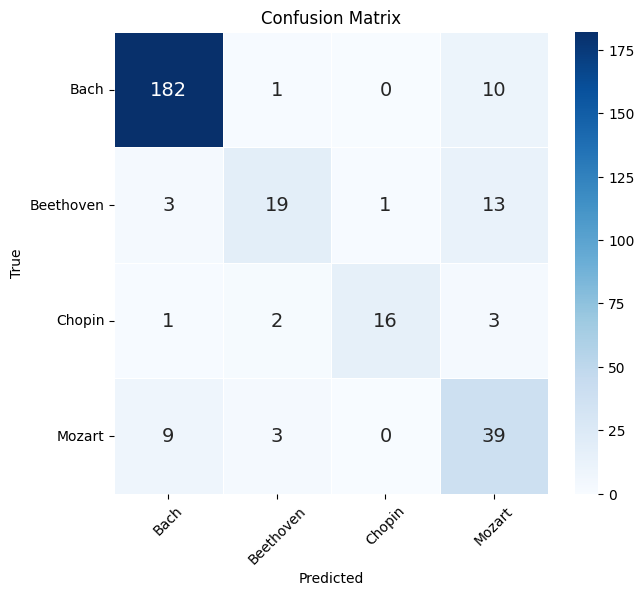

<Figure size 1000x800 with 0 Axes>

In [37]:
# Compute confusion matrix
cmatrix_lstm = confusion_matrix(y_true, y_pred_classes)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
fig, ax = plt.subplots(figsize=figsize)
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap("Blues")

# Create the confusion matrix heatmap
sns.heatmap(cmatrix_lstm, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14})

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
plt.show()

### Plot the ROC-AUC curves

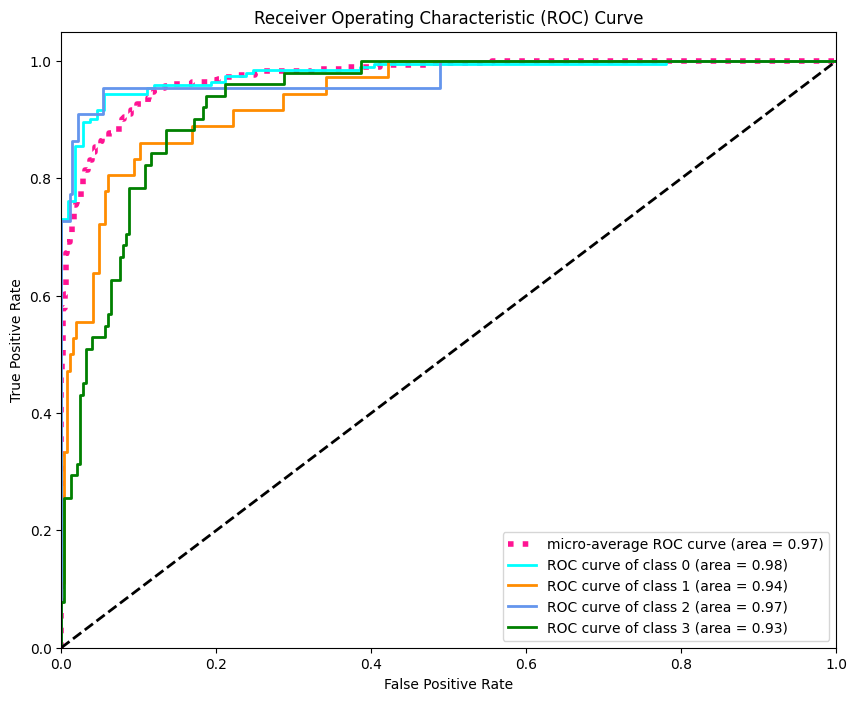

In [38]:
y_test_bin = label_binarize(y_test_seq, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### CNN

#### Build model and train

In [39]:
cnn_model = Sequential([
    # Input normalization
    Input(shape=input_shape),
    BatchNormalization(),
    
    # First convolutional block
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Third convolutional block
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),
    
    # Dense layers
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
result = cnn_model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_test_reshaped, y_test_categorical), epochs=100,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3477 - loss: 1.9490 - val_accuracy: 0.6797 - val_loss: 1.0386 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5364 - loss: 1.2678 - val_accuracy: 0.6993 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6604 - loss: 0.9131 - val_accuracy: 0.7647 - val_loss: 0.6149 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6765 - loss: 0.8484 - val_accuracy: 0.7974 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7175 - loss: 0.7430 - val_accuracy: 0.7712 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7692 - loss: 0.6346 - val_accuracy: 0.8366 - val_loss: 0.5050 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7965 - loss: 0.5565 - 

#### Evaluate training

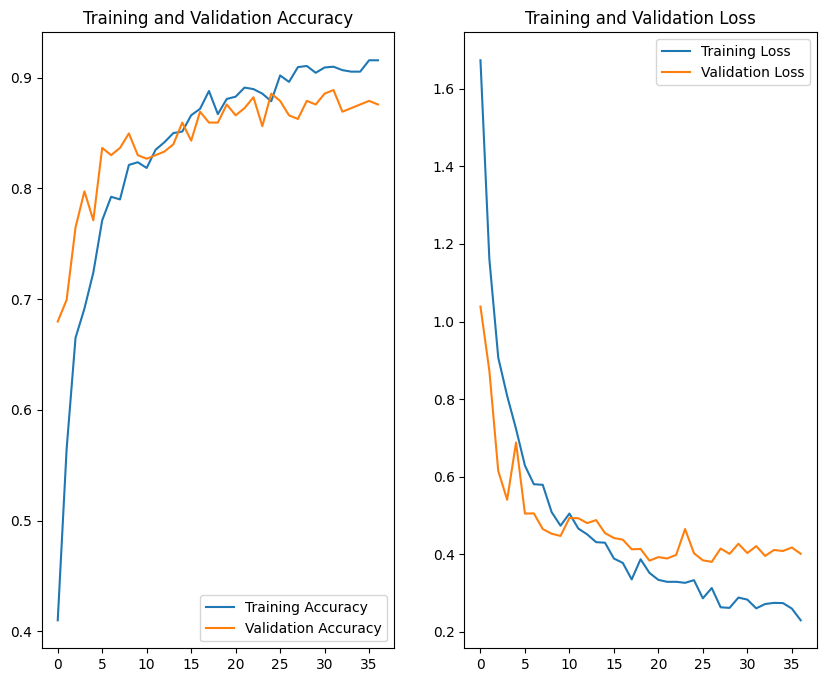

In [40]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Make predictions

In [41]:
y_pred = cnn_model.predict(X_test_reshaped)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [42]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       195
           1       0.74      0.62      0.68        37
           2       0.74      0.77      0.76        22
           3       0.68      0.85      0.75        52

    accuracy                           0.87       306
   macro avg       0.78      0.79      0.78       306
weighted avg       0.87      0.87      0.87       306



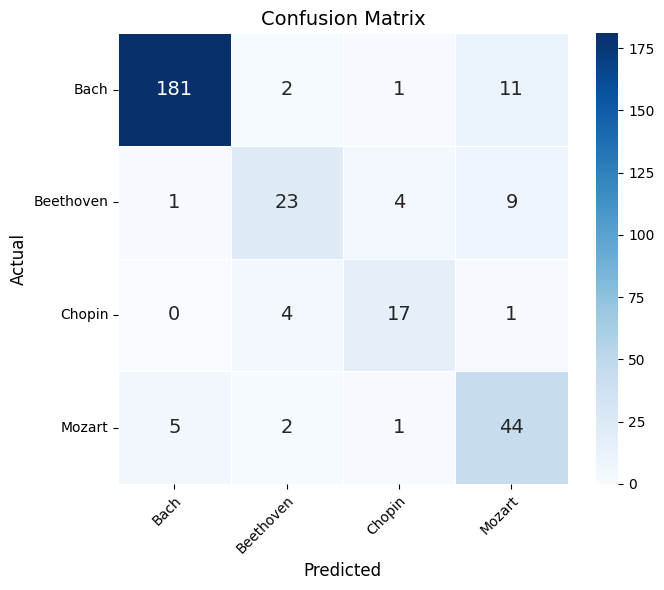

In [43]:
cmatrix_cnn = confusion_matrix(y_test_classes, y_pred_classes)
fontsize = 7
figsize = (7, 6)
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix_cnn, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### Plot the ROC-AUC curves

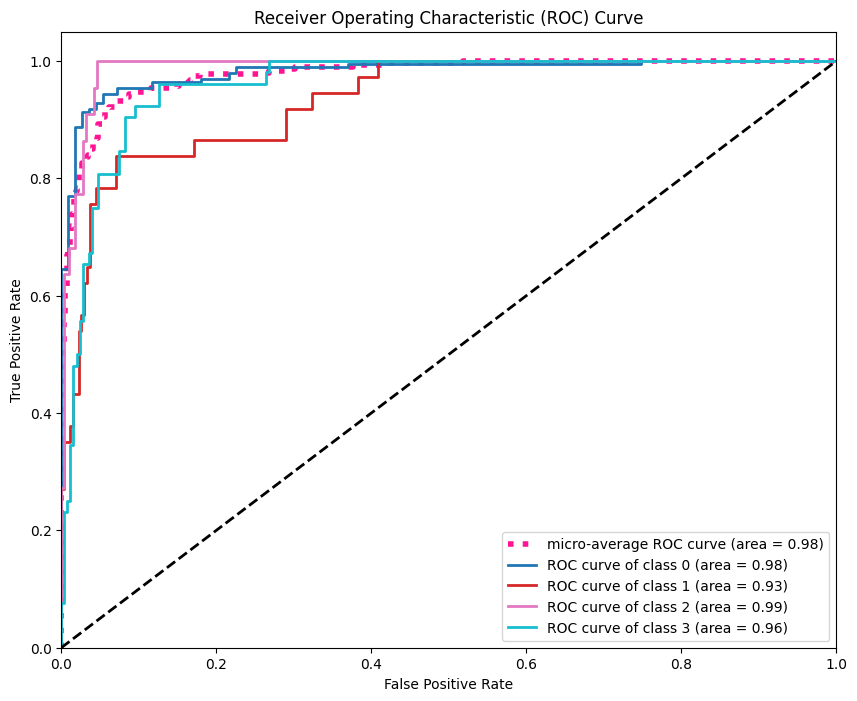

In [44]:
# Binarize the output
y_test_bin = label_binarize(y_test_classes, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, num_classes))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()